In [17]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score
from torch.nn import GELU
from torch_geometric.loader import DataLoader
import pandas as pd

class GCN(torch.nn.Module):
    def __init__(self, nfeat, nhid, nclass, num_layers, dropout, act_type):
        super(GCN, self).__init__()
        self.layers = torch.nn.ModuleList()
        self.layers.append(GCNConv(nfeat, nhid))
        for _ in range(num_layers - 2):
            self.layers.append(GCNConv(nhid, nhid))
        self.layers.append(GCNConv(nhid, nclass))
        self.dropout = dropout
        self.act_type = act_type()

    def forward(self, x, edge_index):
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x, edge_index)
            x = self.act_type(x)
            x = F.dropout(x, self.dropout, training=self.training)
        x = self.layers[-1](x, edge_index)
        return F.log_softmax(x, dim=1)

# Definindo os hiperparâmetros fornecidos
env_args = {
    "model_type": "GCN",
    "num_layers": 8,
    "env_dim": 256,
    "layer_norm": True,
    "skip": True,
    "batch_norm": False,
    "dropout": 0.2,
    "act_type": GELU,
    "in_dim": 300,
    "out_dim": 18,
    "epochs": 1500
}
ID = 8

# Loading the data
path = "./datasets/roman_empire/processed/data.pt"
data = torch.load(path)  # (Data(x=[22662, 300], edge_index=[2, 32927], y=[22662], train_mask=[22662, 10], val_mask=[22662, 10], test_mask=[22662, 10]), None)
data = data[0]

features = data.x
labels = data.y
adj = data.edge_index

# Model and optimizer
model = GCN(nfeat=env_args["in_dim"], nhid=env_args["env_dim"], nclass=env_args["out_dim"], 
            num_layers=env_args["num_layers"], dropout=env_args["dropout"], act_type=env_args["act_type"])

optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=5e-4)

epochs = env_args["epochs"]
fastmode = True
idx_train = data.train_mask[:, 0].nonzero(as_tuple=False).squeeze()
idx_val = data.val_mask[:, 0].nonzero(as_tuple=False).squeeze()
idx_test = data.test_mask[:, 0].nonzero(as_tuple=False).squeeze()

# Convert idx_train to a TensorDataset for DataLoader
train_dataset = torch.utils.data.TensorDataset(idx_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

if torch.cuda.is_available():
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()

# DataFrame to store losses and metrics
losses = pd.DataFrame(columns=["epoch", "time", "train_loss", "val_loss", "test_loss", "train_metric", "val_metric", "test_metric"])

def train(epoch):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        batch_idx = batch[0]
        output = model(features, adj)
        loss_train = F.nll_loss(output[batch_idx], labels[batch_idx])
        pred_train = output[batch_idx].max(1)[1]
        acc_train = accuracy_score(labels[batch_idx].cpu(), pred_train.cpu())
        loss_train.backward()
        optimizer.step()

    if not fastmode:
        model.eval()
        output = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    pred_val = output[idx_val].max(1)[1]
    acc_val = accuracy_score(labels[idx_val].cpu(), pred_val.cpu())

    # Collect metrics for the epoch
    epoch_time = time.time() - t_total
    losses.loc[epoch] = [epoch, epoch_time, loss_train.item(), loss_val.item(), None, acc_train, acc_val, None]

def test():
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    pred_test = output[idx_test].max(1)[1]
    acc_test = accuracy_score(labels[idx_test].cpu(), pred_test.cpu())
    return loss_test.item(), acc_test

# Train model
t_total = time.time()
for epoch in range(epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

# Final testing
loss_test, acc_test = test()

# Add final test metrics to the DataFrame
losses["test_loss"] = loss_test
losses["test_metric"] = acc_test

# Save the DataFrame to a CSV file
losses.to_csv("losses_roman_empire_GCN.csv", index=False)

# Testing
print("Test set results:",
      "loss= {:.4f}".format(loss_test),
      "accuracy= {:.4f}".format(acc_test))

# getting the datapoints csv
datapoints = pd.read_csv("./time_comparison.csv") # columns=["id", "model", "params", "dataset", "time", "accuracy"]

this_datapoint = pd.DataFrame(columns=["id", "model", "params", "dataset", "time", "accuracy"])
this_datapoint["id"] = [ID]
this_datapoint["model"] = ["GCN"]
this_datapoint["params"] = [env_args]
this_datapoint["dataset"] = ["roman_empire"]
this_datapoint["time"] = [time.time() - t_total]
this_datapoint["accuracy"] = [acc_test]

# adding the datapoint
datapoints = pd.concat([datapoints, this_datapoint], ignore_index=True)	

# saving the datapoints
datapoints.to_csv("./time_comparison.csv", index=False)


Optimization Finished!
Total time elapsed: 14540.2796s
Test set results: loss= 2.3918 accuracy= 0.2556


In [24]:
env_dim = env_args["env_dim"]
num_layers = env_args["num_layers"]

In [25]:
# python -u main.py --dataset roman_empire --env_model_type GCN --act_model_type GCN --env_dim 4 --env_num_layers 2 --act_dim 8 --act_num_layers 2 --seed 0 --max_epochs 500 --batch_size 512 --ID 1
!python -u main.py --dataset roman_empire --env_model_type GCN --act_model_type GCN --env_dim {env_dim} --env_num_layers {num_layers} --act_dim 8 --act_num_layers 2 --seed 0 --max_epochs {epochs} --batch_size 128 --ID {ID} --learn_temp --tau0 0.01 --lr 0.003 --skip --layer_norm --dropout 0.2

dataset: DataSet.roman_empire
pool: Pool.NONE
learn_temp: True
temp_model_type: ModelType.LIN
tau0: 0.01
temp: 0.01
max_epochs: 1500
batch_size: 128
lr: 0.003
dropout: 0.2
env_model_type: ModelType.GCN
env_num_layers: 8
env_dim: 256
skip: True
batch_norm: False
layer_norm: True
dec_num_layers: 1
pos_enc: PosEncoder.NONE
act_model_type: ModelType.GCN
act_num_layers: 2
act_dim: 8
seed: 0
gpu: None
fold: None
weight_decay: 0
step_size: None
gamma: None
num_warmup_epochs: None
ID: 8

  0%|          | 0/1500 [00:00<?, ?it/s]
Split: 0, epoch: 0,train_loss=2.79,val_loss=2.79,test_loss=2.79,train_metric=0.26,val_metric=0.26,test_metric=0.26(0.26):   0%|          | 0/1500 [00:01<?, ?it/s]
Split: 0, epoch: 0,train_loss=2.79,val_loss=2.79,test_loss=2.79,train_metric=0.26,val_metric=0.26,test_metric=0.26(0.26):   0%|          | 1/1500 [00:01<39:42,  1.59s/it]
Split: 0, epoch: 1,train_loss=2.71,val_loss=2.71,test_loss=2.71,train_metric=0.24,val_metric=0.24,test_metric=0.24(0.26):   0%|          | 1

c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\graphgym\config.py:19: UserWarning: Could not define global config object. Please install 'yacs' via 'pip install yacs' in order to use GraphGym
  warnings.warn("Could not define global config object. Please install "
c:\Users\lucas\OneDrive\Área de Trabalho\CoGNN\experiments.py:275: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  losses = pd.concat([losses, pd.DataFrame([[epoch, time.time()-trainstart, train_loss, val_loss, test_loss, train_metric, val_metric, test_metric]], columns=losses.columns)], ignore_index=True)


In [31]:
pd.set_option('display.max_colwidth', None)
df = pd.read_csv("./time_comparison.csv") # columns=["id", "model", "params", "dataset", "time", "accuracy"]


In [32]:
# ploting pivoting so each ID have a single row, with a column for each model, having the time and accuracy
df = df.pivot(index="id", columns="model", values=["time", "accuracy"])

In [33]:
# removing the multiindex
df.columns = ["_".join(col).strip() for col in df.columns.values]
df.rename(columns={"time_GCN": "time for GCN", "accuracy_GCN": "accuracy for GCN", "time_ModelType.GCN": "time for CO-GNN(GCN, GCN)", "accuracy_ModelType.GCN": "accuracy for CO-GNN(GCN, GCN)"}, inplace=True)
df

time for GCN  time for CO-GNN(GCN, GCN)  accuracy for GCN  \
id                                                              
1     108.512889                  81.960000          0.337804   
2     129.277137                 111.078413          0.288740   
3     127.572034                 120.500135          0.293329   
4     182.368513                 193.788878          0.219379   
5     191.311088                 150.233141          0.229792   
6     185.488246                 163.727025          0.255383   
7     525.496028                 410.279302          0.382280   

    accuracy for CO-GNN(GCN, GCN)  
id                                 
1                        0.414225  
2                        0.256795  
3                        0.180198  
4                        0.154253  
5                        0.171020  
6                        0.344335  
7                        0.444935

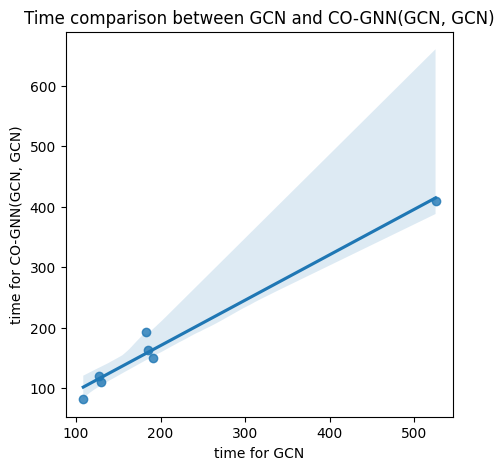

In [35]:
# plot the times, x is the time for GCN, y is the time for CO-GNN(GCN, GCN)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 5))
# regresion line
sns.regplot(x="time for GCN", y="time for CO-GNN(GCN, GCN)", data=df)
plt.title("Time comparison between GCN and CO-GNN(GCN, GCN)")
plt.show()

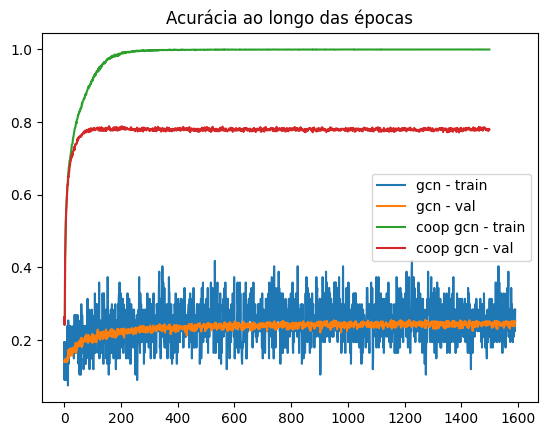

In [36]:
losses_coop_gcn = pd.read_csv("losses_roman_empire_ModelType.GCN_0.csv")
losses_gcn = pd.read_csv("losses_roman_empire_GCN.csv")

# plotando as metricas ao longo do treinamento
plt.plot(losses_gcn['epoch'], losses_gcn['train_metric'], label='gcn - train')
plt.plot(losses_gcn['epoch'], losses_gcn['val_metric'], label='gcn - val')
plt.plot(losses_gcn['epoch'], losses_gcn['test_metric'], label='gcn - test')
plt.plot(losses_coop_gcn['epoch'], losses_coop_gcn['train_metric'], label='coop gcn - train')
plt.plot(losses_coop_gcn['epoch'], losses_coop_gcn['val_metric'], label='coop gcn - val')
plt.plot(losses_coop_gcn['epoch'], losses_coop_gcn['test_metric'], label='coop gcn - test')
plt.legend()
plt.title('Acurácia ao longo das épocas')
plt.show()

In [ ]:
# 8,GCN,"{'model_type': 'GCN', 'num_layers': 8, 'env_dim': 256, 'layer_norm': True, 'skip': True, 'batch_norm': False, 'dropout': 0.2, 'act_type': <class 'torch.nn.modules.activation.GELU'>, 'in_dim': 300, 'out_dim': 18, 'epochs': 3000}",roman_empire,14540.649580478668,0.2555594775855983
# 8,ModelType.GCN,"EnvArgs(model_type=<ModelType.GCN: 1>, num_layers=8, env_dim=256, layer_norm=True, skip=True, batch_norm=False, dropout=0.2, act_type=<ActivationType.GELU: 2>, dec_num_layers=1, pos_enc=<PosEncoder.NONE: 1>, dataset_encoders=<DataSetEncoders.NONE: 1>, metric_type=<MetricType.ACCURACY: 1>, in_dim=300, out_dim=18, gin_mlp_func=<function DataSet.gin_mlp_func.<locals>.mlp_func at 0x000001726D512FC0>)","{'metric': <MetricType.ACCURACY: 1>, 'dataset_name': 'roman_empire', 'node_based': True, 'family': <DataSetFamily.heterophilic: 1>}",1790.1940791606903,0.7767384648323059
